In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score, cross_validate
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from statistics import mean


In [2]:
data = pd.read_csv('full_data_flightdelay.csv')
data


,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,1,7,0,0800-0859,2,1,25,143,Southwest Airlines Co.,13056,...,8,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
1,1,7,0,0700-0759,7,1,29,191,Delta Air Lines Inc.,13056,...,3,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
2,1,7,0,0600-0659,7,1,27,199,Delta Air Lines Inc.,13056,...,18,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
3,1,7,0,0600-0659,9,1,27,180,Delta Air Lines Inc.,13056,...,2,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
4,1,7,0,0001-0559,7,1,10,182,Spirit Air Lines,13056,...,1,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6489057,12,7,0,2300-2359,1,11,3,123,Hawaiian Airlines Inc.,1318,...,18,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21
6489058,12,7,0,1800-1859,1,11,2,123,Hawaiian Airlines Inc.,1318,...,16,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21
6489059,12,7,0,2000-2059,1,11,2,123,Hawaiian Airlines Inc.,1318,...,18,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21
6489060,12,7,0,2100-2159,1,12,3,123,Hawaiian Airlines Inc.,1318,...,18,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21


In [3]:
df = data.copy()

In [4]:
carriers = df['CARRIER_NAME'].value_counts()
carriers = carriers.index.values.tolist()
df['CARRIER_NAME'] = df['CARRIER_NAME'].replace(carriers, range(len(carriers)))

In [5]:
deps = df['DEP_TIME_BLK'].value_counts()
deps = deps.index.values.tolist()
df['DEP_TIME_BLK'] = df['DEP_TIME_BLK'].replace(deps, range(len(deps)))

In [6]:
airport = df['DEPARTING_AIRPORT'].value_counts()
airport = airport.index.values.tolist()
df['DEPARTING_AIRPORT'] = df['DEPARTING_AIRPORT'].replace(airport, range(len(airport)))

In [7]:
prev_airport = df['PREVIOUS_AIRPORT'].value_counts()
prev_airport = prev_airport.index.values.tolist()
df['PREVIOUS_AIRPORT'] = df['PREVIOUS_AIRPORT'].replace(prev_airport, range(len(prev_airport)))

In [8]:
df.dtypes

MONTH                              int64
DAY_OF_WEEK                        int64
DEP_DEL15                          int64
DEP_TIME_BLK                       int64
DISTANCE_GROUP                     int64
SEGMENT_NUMBER                     int64
CONCURRENT_FLIGHTS                 int64
NUMBER_OF_SEATS                    int64
CARRIER_NAME                       int64
AIRPORT_FLIGHTS_MONTH              int64
AIRLINE_FLIGHTS_MONTH              int64
AIRLINE_AIRPORT_FLIGHTS_MONTH      int64
AVG_MONTHLY_PASS_AIRPORT           int64
AVG_MONTHLY_PASS_AIRLINE           int64
FLT_ATTENDANTS_PER_PASS          float64
GROUND_SERV_PER_PASS             float64
PLANE_AGE                          int64
DEPARTING_AIRPORT                  int64
LATITUDE                         float64
LONGITUDE                        float64
PREVIOUS_AIRPORT                   int64
PRCP                             float64
SNOW                             float64
SNWD                             float64
TMAX            

In [9]:
tdf = df.copy()

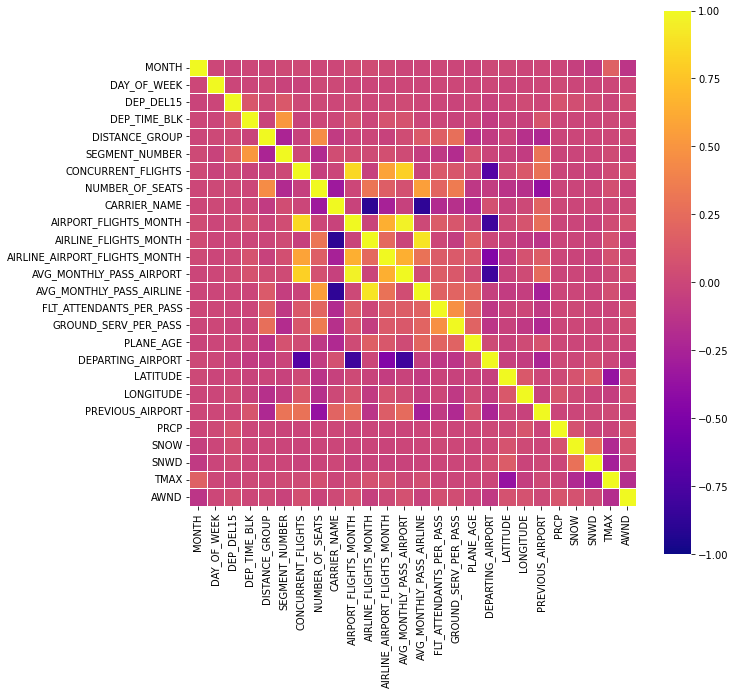

In [10]:
fig, ax = plt.subplots(figsize=(10,10))

corr_mat = df.corr()
sns.heatmap(corr_mat, square=True, cmap='plasma', linewidths=.5, ax=ax, vmin = -1, vmax = 1)
pass

In [11]:
corr_mat['DEP_DEL15']

MONTH                           -0.019049
DAY_OF_WEEK                     -0.000199
DEP_DEL15                        1.000000
DEP_TIME_BLK                     0.109707
DISTANCE_GROUP                   0.016289
SEGMENT_NUMBER                   0.117528
CONCURRENT_FLIGHTS               0.009028
NUMBER_OF_SEATS                  0.011845
CARRIER_NAME                     0.002282
AIRPORT_FLIGHTS_MONTH            0.026740
AIRLINE_FLIGHTS_MONTH            0.003528
AIRLINE_AIRPORT_FLIGHTS_MONTH    0.013711
AVG_MONTHLY_PASS_AIRPORT         0.024383
AVG_MONTHLY_PASS_AIRLINE         0.001257
FLT_ATTENDANTS_PER_PASS         -0.002114
GROUND_SERV_PER_PASS            -0.016736
PLANE_AGE                        0.006220
DEPARTING_AIRPORT               -0.037350
LATITUDE                         0.000490
LONGITUDE                        0.027097
PREVIOUS_AIRPORT                 0.001224
PRCP                             0.080277
SNOW                             0.050156
SNWD                             0

Избавляемся от данных, зависимость от которых мала

In [12]:
df = df.drop(['DAY_OF_WEEK', 'CARRIER_NAME', 'AIRLINE_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRLINE', 'FLT_ATTENDANTS_PER_PASS', 'PLANE_AGE', 'LATITUDE', 'TMAX', 'CONCURRENT_FLIGHTS', 'PREVIOUS_AIRPORT'], axis = 1)
df

,MONTH,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,GROUND_SERV_PER_PASS,DEPARTING_AIRPORT,LONGITUDE,PRCP,SNOW,SNWD,AWND
0,1,0,0,2,1,143,13056,5873,1903352,0.000099,10,-115.152,0.00,0.0,0.0,2.91
1,1,0,1,7,1,191,13056,1174,1903352,0.000149,10,-115.152,0.00,0.0,0.0,2.91
2,1,0,2,7,1,199,13056,1174,1903352,0.000149,10,-115.152,0.00,0.0,0.0,2.91
3,1,0,2,9,1,180,13056,1174,1903352,0.000149,10,-115.152,0.00,0.0,0.0,2.91
4,1,0,17,7,1,182,13056,1257,1903352,0.000125,10,-115.152,0.00,0.0,0.0,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6489057,12,0,18,1,11,123,1318,757,133573,0.000198,86,-159.346,0.06,0.0,0.0,15.21
6489058,12,0,10,1,11,123,1318,757,133573,0.000198,86,-159.346,0.06,0.0,0.0,15.21
6489059,12,0,14,1,11,123,1318,757,133573,0.000198,86,-159.346,0.06,0.0,0.0,15.21
6489060,12,0,15,1,12,123,1318,757,133573,0.000198,86,-159.346,0.06,0.0,0.0,15.21


Больше всего самолетов отменяют в июне(относительно общего числа полетов)

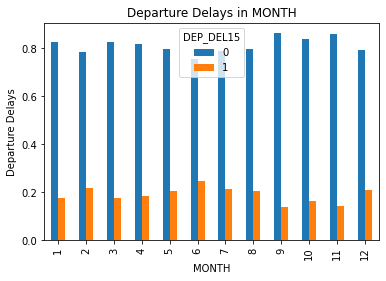

In [13]:
pd.crosstab(data.MONTH, data.DEP_DEL15, normalize='index' ).plot(kind='bar')
plt.title('Departure Delays in MONTH')
plt.xlabel('MONTH')
plt.ylabel('Departure Delays')
plt.savefig('Departure Delays in MONTH')

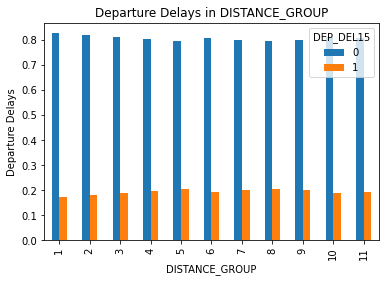

In [14]:
pd.crosstab(data.DISTANCE_GROUP, data.DEP_DEL15, normalize='index' ).plot(kind='bar')
plt.title('Departure Delays in DISTANCE_GROUP')
plt.xlabel('DISTANCE_GROUP')
plt.ylabel('Departure Delays')
plt.savefig('Departure Delays in DISTANCE_GROUP')

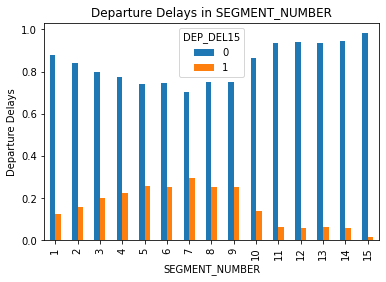

In [15]:
pd.crosstab(data.SEGMENT_NUMBER, data.DEP_DEL15, normalize='index' ).plot(kind='bar')
plt.title('Departure Delays in SEGMENT_NUMBER')
plt.xlabel('SEGMENT_NUMBER')
plt.ylabel('Departure Delays')
plt.savefig('Departure Delays in SEGMENT_NUMBER')

In [16]:
# cols=df.columns
# feats = df.iloc[:,:25] 

# threshold = 0.3

# corr_list = []
# for i in range(25):
#     for j in range(i + 1, 24):
#         if (corr_mat.iloc[i,j] >= threshold and corr_mat.iloc[i,j] < 1) or (corr_mat.iloc[i,j] < 0 and corr_mat.iloc[i,j] <= -threshold):
#             corr_list.append([corr_mat.iloc[i,j],i,j])

# for _,i,j in corr_list:
#     sns.pairplot(df, hue="DEP_DEL15", height=8, x_vars=cols[i],y_vars=cols[j])
#     plt.show()

In [17]:
req = 100000
c2 = df[df['DEP_DEL15'] == 1]
c1 = df[df['DEP_DEL15'] == 0]
df_2 = c2.sample(req)
df_1 = c1.sample(req)
df = pd.concat([df_2,df_1],axis=0)

In [18]:
X = df.drop('DEP_DEL15', axis = 1)
y = df['DEP_DEL15']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=17)

In [20]:
X_train

,MONTH,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,GROUND_SERV_PER_PASS,DEPARTING_AIRPORT,LONGITUDE,PRCP,SNOW,SNWD,AWND
3324378,7,15,7,6,178,29376,884,3103410,0.000125,1,-87.906,1.36,0.0,0.0,10.96
1077872,3,9,1,4,143,4122,287,364314,0.000099,44,-84.669,0.00,0.0,0.0,8.28
5995271,12,7,2,2,50,12707,3467,1581456,0.000099,12,-93.218,0.69,0.0,0.0,14.99
3719250,7,15,3,5,143,7297,6862,819756,0.000099,26,-87.752,0.00,0.0,0.0,13.87
3042140,6,4,8,2,187,13892,4721,1827202,0.000177,7,-112.009,0.00,0.0,0.0,8.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3352290,7,17,6,1,143,14275,5036,1827202,0.000099,7,-112.009,0.00,0.0,0.0,6.04
431254,1,8,8,4,191,30842,18809,4365661,0.000149,0,-84.427,0.00,0.0,0.0,5.14
3226352,7,3,3,3,199,7705,941,1391212,0.000149,22,-80.152,0.07,0.0,0.0,4.03
4125643,8,13,9,3,172,14177,4675,1827202,0.000177,7,-112.009,0.00,0.0,0.0,4.47


In [21]:
neighbors = np.arange(1,7)
train = []
test = []
for i,k in enumerate(neighbors):
    knn = Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier(n_neighbors=k, n_jobs=-1))])
    knn.fit(X_train, y_train)
    train.append(knn.score(X_train, y_train))
    test.append(knn.score(X_test, y_test))
    print(f'{k} done')

1 done
2 done
3 done
4 done
5 done
6 done


0.5941333333333333

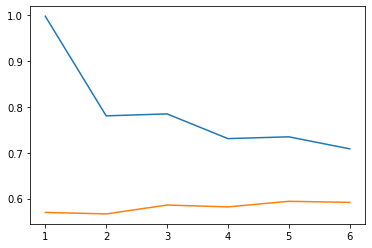

In [23]:
plt.plot(np.arange(1,7), train)
plt.plot(np.arange(1,7), test)
max(test)

In [30]:
from sklearn import tree
model = tree.DecisionTreeClassifier()
mean(cross_val_score(model, X_train, y_train))

0.5672357142857143